# Searching for Similar Board Games

System that finds similar board games to the given game

Input = Name of game or ID

Output = List of Board Games sorted by Similarity (with some threshold)

Initial Comments:
- My guess is this is about recommending similar board games to users. Given a game, use data (primary textual descriptions) to suggest similar items.
- Ultimately, this should be driven by a combination of factors to define similarity between two items
- Two of the most important factors to drive the similarities are generes/themes (category) and game play (mechanic)
- Other significant factors would probably be number of players and average time required to finish the game (not going to focus on this aspect as per requirement)
- Also, free text description will probably provide good detailed information about the content of the game beyond category and mechanic. More like generating a sub category?

Outline of Approach:
1. Do Initial Grouping by Category & Mechanic
2. Within the group, sort by the similarity of description
- dimension reduction (lsa or lda or word embedding)? - maybe use some existing clusters online for brown clusters, fasttext etc?

Technical challenge:
- For getting simialrity of description, how to automatically 'highlight' what is important vs non-important

In [1]:
import pandas as pd
import numpy as np
import sys
from collections import Counter
import matplotlib.pyplot as plt
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics.pairwise import euclidean_distances, cosine_distances, cosine_similarity
from itertools import product
%matplotlib inline
# import nltk

In [2]:
df = pd.read_csv('gakudataset.csv')

In [3]:
print "how many records?"
print df.shape
print df.columns

how many records?
(90328, 28)
Index([u'game.id', u'details.description', u'details.image',
       u'details.maxplayers', u'details.maxplaytime', u'details.minage',
       u'details.minplayers', u'details.minplaytime', u'details.name',
       u'details.playingtime', u'details.thumbnail', u'details.yearpublished',
       u'attributes.boardgameartist', u'attributes.boardgamecategory',
       u'attributes.boardgamedesigner', u'attributes.boardgameexpansion',
       u'attributes.boardgamemechanic', u'attributes.total', u'stats.average',
       u'stats.numcomments', u'stats.numweights', u'stats.owned',
       u'stats.subtype.boardgame.pos', u'stats.trading', u'stats.usersrated',
       u'stats.wanting', u'stats.wishing', u'polls.suggested_playerage'],
      dtype='object')


In [4]:
df.head(5)

,game.id,details.description,details.image,details.maxplayers,details.maxplaytime,details.minage,details.minplayers,details.minplaytime,details.name,details.playingtime,...,stats.average,stats.numcomments,stats.numweights,stats.owned,stats.subtype.boardgame.pos,stats.trading,stats.usersrated,stats.wanting,stats.wishing,polls.suggested_playerage
0,1.0,Die Macher is a game about seven sequential po...,//cf.geekdo-images.com/images/pic159509.jpg,5.0,240.0,14.0,3.0,240.0,Die Macher,240.0,...,7.66508,1763.0,719.0,5251.0,147.0,170.0,4498.0,505.0,1654.0,14.0
1,2.0,Dragonmaster is a trick-taking card game based...,//cf.geekdo-images.com/images/pic184174.jpg,4.0,30.0,12.0,3.0,30.0,Dragonmaster,30.0,...,6.60815,273.0,52.0,1053.0,2541.0,73.0,478.0,67.0,161.0,NaN
2,3.0,"Part of the Knizia tile-laying trilogy, Samura...",//cf.geekdo-images.com/images/pic3211873.jpg,4.0,60.0,10.0,2.0,30.0,Samurai,60.0,...,7.44119,3281.0,1355.0,11870.0,150.0,234.0,12019.0,707.0,2601.0,10.0
3,4.0,When you see the triangular box and the luxuri...,//cf.geekdo-images.com/images/pic285299.jpg,4.0,60.0,12.0,2.0,60.0,Tal der K�nige,60.0,...,6.60675,111.0,30.0,523.0,3191.0,29.0,314.0,61.0,112.0,14.0
4,5.0,"In Acquire, each player strategically invests ...",//cf.geekdo-images.com/images/pic342163.jpg,6.0,90.0,12.0,3.0,90.0,Acquire,90.0,...,7.35830,5011.0,1515.0,18682.0,181.0,823.0,15195.0,516.0,2219.0,12.0


0 records have null ID? 
i am going to get rid of records with null ids - these need a separate inquiry, outside of the current scope


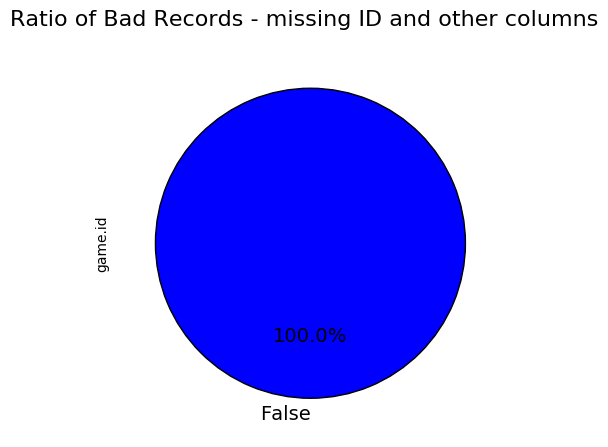

In [55]:
print str(np.sum(df['game.id'].isnull())) + " records have null ID? "
print 'i am going to get rid of records with null ids - these need a separate inquiry, outside of the current scope'


fig = plt.figure(figsize=(5,5))
# plot chart
ax1 = plt.subplot(111, aspect='equal')
fig.suptitle('Ratio of Bad Records - missing ID and other columns', fontsize=16)
df['game.id'].isnull().value_counts(sort=False).plot(kind='pie', ax=ax1, autopct='%1.1f%%', 
                                                     startangle=90, shadow=False, legend = False, fontsize=14)

# removing bad records from the data
df = df[~df['game.id'].isnull()]
df['game.id'] = df['game.id'].astype(int)
# df = df.set_index('game.id')

In [6]:
print "let's take a look at the 3 key text columns"
df[['details.description', 'attributes.boardgamecategory', 'attributes.boardgamemechanic']].head(10)

let's take a look at the 3 key text columns


,details.description,attributes.boardgamecategory,attributes.boardgamemechanic
0,Die Macher is a game about seven sequential po...,"Economic,Negotiation,Political","Area Control / Area Influence,Auction/Bidding,..."
1,Dragonmaster is a trick-taking card game based...,"Card Game,Fantasy",Trick-taking
2,"Part of the Knizia tile-laying trilogy, Samura...","Abstract Strategy,Medieval","Area Control / Area Influence,Hand Management,..."
3,When you see the triangular box and the luxuri...,Ancient,"Action Point Allowance System,Area Control / A..."
4,"In Acquire, each player strategically invests ...",Economic,"Hand Management,Stock Holding,Tile Placement"
5,"In the ancient lands along the Mediterranean, ...","Civilization,Nautical",Dice Rolling
6,"In Cathedral, each player has a set of pieces ...",Abstract Strategy,"Area Enclosure,Pattern Building,Pattern Recogn..."
7,"In this interesting offering from Warfrog, pla...","Civilization,Fantasy",Modular Board
8,"Although referred to as a sequel to El Grande,...",Exploration,"Area Control / Area Influence,Tile Placement"
9,Elfenland is a redesign of the original White ...,"Fantasy,Travel","Card Drafting,Hand Management,Point to Point M..."


## Part 1: Data Exploration

In [7]:
df['attributes.boardgamecategory'].isnull().value_counts()

False    75297
True      1391
Name: attributes.boardgamecategory, dtype: int64

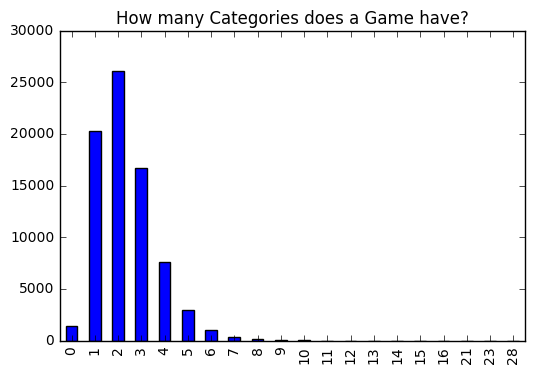

In [8]:
# df['attributes.boardgamecategory'] = df['attributes.boardgamecategory'].fillna('')
df['category_list'] = df['attributes.boardgamecategory'].fillna('').apply(lambda x: x.split(',') if x!='' else [])

df['category_count'] = df['category_list'].apply(lambda x: len(set(x))) # set to get unique list of categories - not sure duplicates
df['category_count'].value_counts().sort_index().plot(kind = 'bar')
plt.title("How many Categories does a Game have?")

In [9]:
print "these records have more than 12 categories... that's crazy but sure"
df[df['category_count']>=12].category_list[:10]

these records have more than 12 categories... that's crazy but sure


4725     [Abstract Strategy, Adventure, Card Game, Dice...
5758     [American Civil War, American Indian Wars, Ame...
6345     [American West, Aviation / Flight, Card Game, ...
8694     [Abstract Strategy, Action / Dexterity, Advent...
9355     [Adventure, American Civil War, American Revol...
12588    [Abstract Strategy, Action / Dexterity, Ancien...
16125    [American Civil War, Ancient, Book, Fighting, ...
17296    [American Civil War, American Indian Wars, Ame...
19924    [American Civil War, Ancient, Book, Civil War,...
21164    [Animals, Bluffing, Book, Card Game, Children'...
Name: category_list, dtype: object

Number of distinct categories = 84


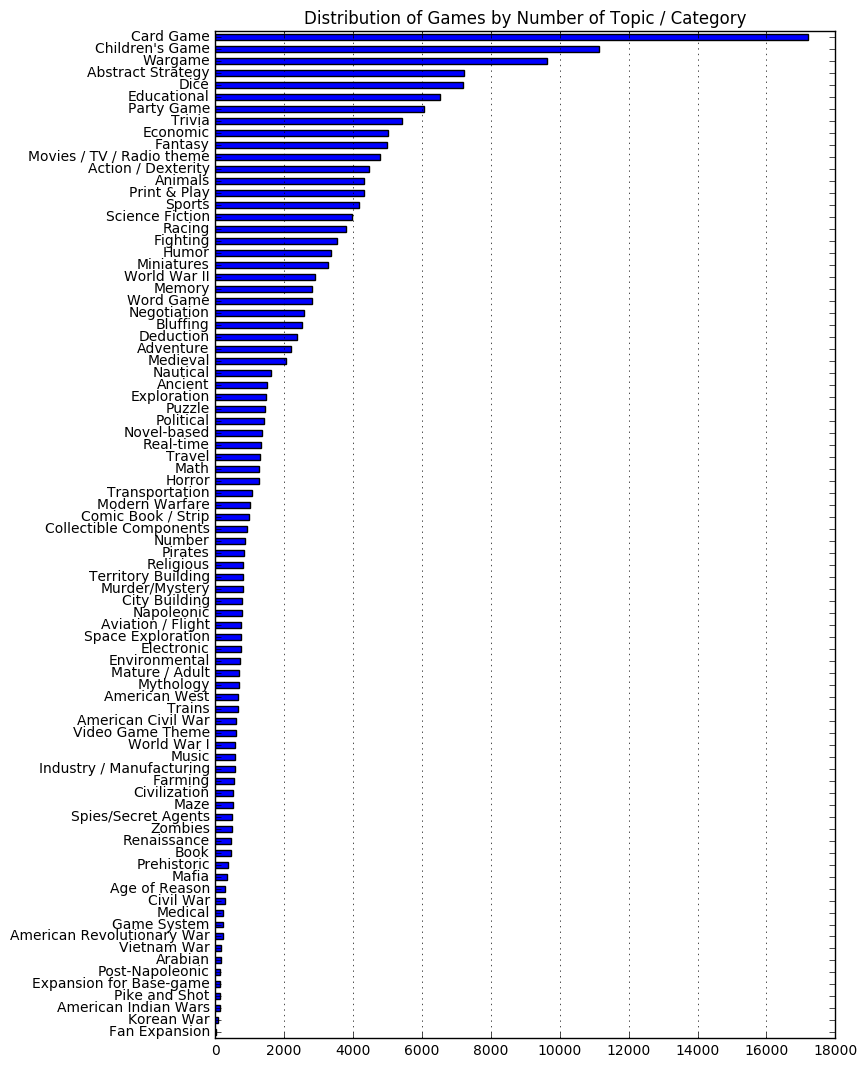

In [10]:
category_full_list = [category for record in df['category_list'].tolist() for category in record]
print "Number of distinct categories = " + str(len(set(category_full_list)))

fig = plt.figure(figsize=(8,13), dpi=1600) 
pd.Series(category_full_list).value_counts().sort_values().plot(kind='barh')
plt.grid(b=True, which='major', axis='x') 
plt.title("Distribution of Games by Number of Topic / Category") 

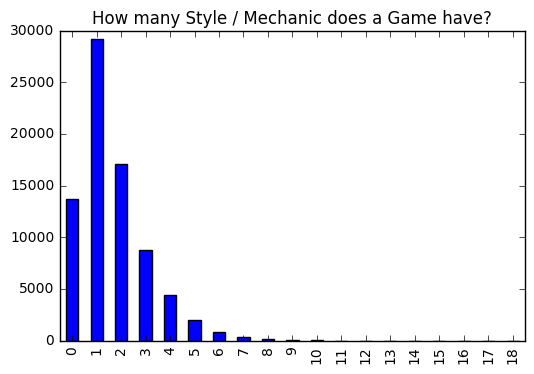

In [11]:
df['mechanic_list'] = df['attributes.boardgamemechanic'].fillna('').apply(lambda x: x.split(',') if x!='' else [])

df['mechanic_count'] = df['mechanic_list'].apply(lambda x: len(set(x))) # set to get unique list of categories - not sure duplicates
df['mechanic_count'].value_counts().sort_index().plot(kind = 'bar')
plt.title("How many Style / Mechanic does a Game have?")    

Number of distinct categories = 51


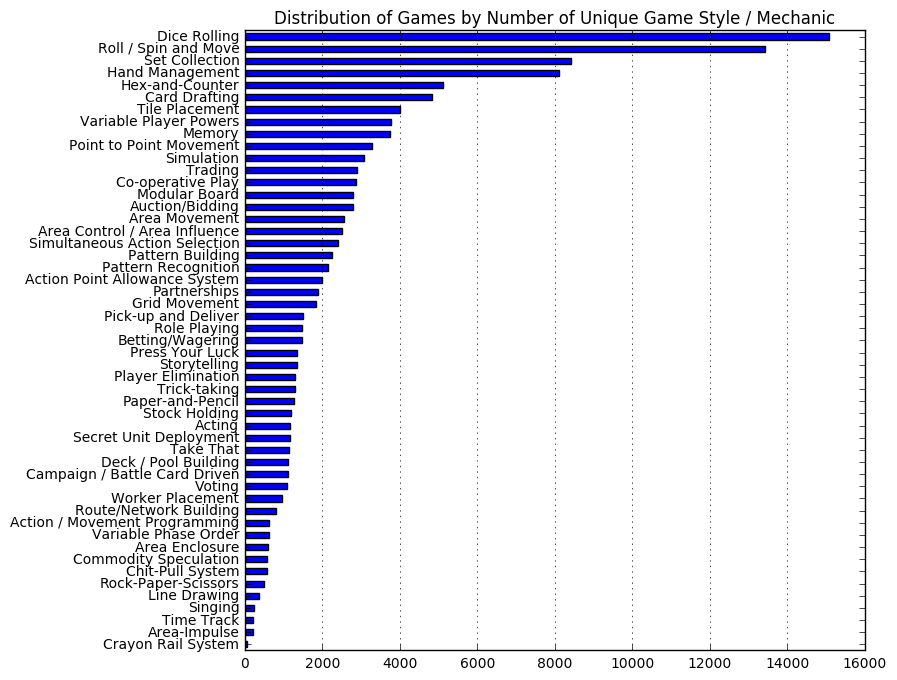

In [12]:
mechanic_full_list = [category for record in df['mechanic_list'].tolist() for category in record]
print "Number of distinct categories = " + str(len(set(mechanic_full_list)))

fig = plt.figure(figsize=(8,8), dpi=1600) 
pd.Series(mechanic_full_list).value_counts().sort_values().plot(kind='barh')
plt.grid(b=True, which='major', axis='x') 

plt.title("Distribution of Games by Number of Unique Game Style / Mechanic")  

## Category & Mechanic Similarity Scores

In [16]:
#pre-compute cosine similarities for all the existing combinations of category and mechanic against all records.

def tokenizer(string):
    return string.split(',')

category_unique_list = list(set(df[~df['attributes.boardgamecategory'].isnull()]['attributes.boardgamecategory']))
category_name_index_dict = {category_unique_list[i]:i for i in range(len(category_unique_list))}
category_name_index_dict[np.nan] = np.nan
category_distinct_matrix = CountVectorizer(tokenizer = tokenizer).fit_transform(category_unique_list)

CategoryVectorizer = CountVectorizer(tokenizer = tokenizer, stop_words=[''])
category_matrix = CategoryVectorizer.fit_transform(df['attributes.boardgamecategory'].fillna(''))
category_similarity_matrix = cosine_similarity(category_distinct_matrix, category_matrix,dense_output=False)

# repeat above for mechanic: create mechanic similarity matrix
mechanic_unique_list = list(set(df[~df['attributes.boardgamemechanic'].isnull()]['attributes.boardgamemechanic']))
mechanic_name_index_dict = {mechanic_unique_list[i]:i for i in range(len(mechanic_unique_list))}
mechanic_name_index_dict[np.nan] = np.nan
mechanic_distinct_matrix = CountVectorizer(tokenizer = tokenizer).fit_transform(mechanic_unique_list)

MechanicVectorizer = CountVectorizer(tokenizer = tokenizer, stop_words=[''])
mechanic_matrix = MechanicVectorizer.fit_transform(df['attributes.boardgamemechanic'].fillna(''))
mechanic_similarity_matrix = cosine_similarity(mechanic_distinct_matrix,mechanic_matrix, dense_output=False)

In [25]:
# given input category or mechanic, get category and mechanic similarity scores against the all_records
def category_mechanic_similarity_score(input_index, similarity_matrix):
    """
    given input index for category or mechanic list (combinations), return similairty scores wtr all_records
    input_index: index corresponding to category_list or mechanic_list and sim matrix
    similarity_matrix: category_similarity_matrix or mechanic_similarity_matrix (each row/col = unique list of cat or mechanic)
    
    similarity_scores: 1D array of similarity scores based on similarity matrix and input (category or mechanic)
    """
    if np.isnan(input_index):
        similarity_scores = np.zeros(similarity_matrix.shape[1])
    else:
        similarity_scores = similarity_matrix[input_index].toarray().squeeze()
    return similarity_scores

def get_category_index(category_name):
    if category_name in category_name_index_dict.keys():
        return category_name_index_dict[category_name]
    else:
        print 'Category name combination not found - need to handle this exception later'

def get_mechanic_index(mechanic_name):
    return mechanic_name_index_dict[mechanic_name]

def category_similarity_score(category_name):
    category_index = get_category_index(category_name)
    category_similarity_score = category_mechanic_similarity_score(category_index, category_similarity_matrix)
    return category_similarity_score

def mechanic_similarity_score(mechanic_name):
    mechanic_index = get_mechanic_index(mechanic_name)
    mechanic_similarity_score = category_mechanic_similarity_score(mechanic_index, mechanic_similarity_matrix)
    return mechanic_similarity_score

In [54]:
print 'closest top 5 ids based on category and mechanic'

for input_game_id in df['game.id'][:3]:
    category_scores = category_similarity_score(df[df['game.id']==input_game_id]['attributes.boardgamecategory'].iloc[0])
    mechanic_scores = mechanic_similarity_score(df[df['game.id']==input_game_id]['attributes.boardgamemechanic'].iloc[0])
    total_scores = category_scores + mechanic_scores
    print "ID " + str(input_game_id)
    print df[df['game.id']==input_game_id]['attributes.boardgamecategory'].iloc[0]
    print df[df['game.id']==input_game_id]['attributes.boardgamemechanic'].iloc[0]
    print np.sort(-total_scores)[:5]
    print np.argsort(-total_scores)[:5]

closest top 5 ids based on category and mechanic
ID 1
Economic,Negotiation,Political
Area Control / Area Influence,Auction/Bidding,Dice Rolling,Hand Management,Simultaneous Action Selection
[-2.         -1.44895211 -1.44895211 -1.4472136  -1.35194694]
[    0 67882 19530   413   949]
ID 2
Card Game,Fantasy
Trick-taking
[-2. -2. -2. -2. -2.]
[44412     1 26438 65450 20057]
ID 3
Abstract Strategy,Medieval
Area Control / Area Influence,Hand Management,Set Collection,Tile Placement
[-2.         -1.61237244 -1.57313218 -1.57313218 -1.57313218]
[    2    80 74290 68386 26335]


## Description Similarity 

In [ ]:
"get the top N words"
"get the top n words for each category"
"get rid of irrelevant words"
"do text normalization (lemmanization etc)"
"do topic modelling to get similarity"
"maybe do word embedding?"
"do category + mechanic filtering and then topic modelling similairty"